In [ ]:
%reset

In [ ]:
pip install pyts matplotlib 

In [ ]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support as score

import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM
from tensorflow.keras.models import Model



print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2021-10-08 05:47:47.655510: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2021-10-08 05:47:48.975556: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2021-10-08 05:47:49.741900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-10-08 05:47:49.741965: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-10-08 05:47:49.755176: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-10-08 05:47:49.755247: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2021-10-08 05:47:49.762280: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#M - months A - appliances N - num of imgs 

#file_name ="UKDALE_GAF_1h_18M9A1000N"
#file_name= "UKDALE_GAF_1h_12M10A300N"
#file_name = "UKDALE_GAF_1h_12M10A500N"
#file_name = "UK-DALE_GADF_60m_300S0X_9A5000N_NmB" # x is n of paralel imgs


#file_name = "test_REFIT+ECO+UKDALE+IAWE_GASF_13m100S10X"
file_name = "ALL3_incl_short_13m_100S10X_Y-S_AVG-Y"

dir_path =os.path.abspath(os.getcwd())

#check if we are in cloud or in PC
try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("reading from cloud...")
    path = "/content/drive/MyDrive/Colab Notebooks/NILM/GAF_DS_UNZIPPED/"f"{file_name}"
    #path = "/content/drive/MyDrive/Colab Notebooks/NILM/GAF_DS/old2/"
except:
    print("reading from HDD")
    path = dir_path+"/data"

#check if file exists
try:
    file = h5py.File(f"{path}""/"f"{file_name}""/"f"{file_name}"".hdf5","r+")
    print("file exists, reading it...")
except:
    print("error reading the file!")


# function to make reading easier
def read_many_hdf5(group_name,image_set_name):
    """ 
    Reads image from HDF5.
    """
    images = []

    # Open the HDF5 file
    file = h5py.File(f"{path}""/"f"{file_name}"".hdf5", "r+")

    images = np.array(file[f"{group_name}""/"f"{image_set_name}"])

    return images

reading from HDD
file exists, reading it...


In [ ]:
def plot_confusion_matrix_norm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    

    plt.title(title)



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')
    plt.colorbar()

In [ ]:
def LSTM_3D(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a)
    
 
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [ ]:
def LSTM_3D_base_layers(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a)
    
    x.trainable = False
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    x.trainable = False
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x.trainable = False
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x.trainable = False
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    base_layers = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    
    return base_layers

In [ ]:
def LSTM_Dense2(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(8, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(8, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)
    #out = Dense(16, activation = 'relu')(out)
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [ ]:
def basic_cnn_functional(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])
    
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(input_a)
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.10)(x)
    
    
    
    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = Flatten()(out)
    # dense layer with 50 neurons
    dense = Dense(64, activation = 'relu')(out)
    # final layer with 10 neurons to classify the instances
    output = Dense(num_classes, activation = 'softmax')(dense)
    
    adam = optimizers.Adam(lr = lr)
    model = keras.models.Model(inputs=input_a, outputs=output)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [ ]:
appliance_set = set()

datasets = ["refit"]
for dataset in datasets:
      
     for appliance in file[dataset].keys():

        for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
            appliance_set.add(appliance)

available_appliances = list(appliance_set)
print(available_appliances)

In [ ]:
##load datastset for normal use
data = np.empty([0,10,100,100,1])

labels = np.empty(0)
labels_ds = np.empty(0)

datasets = ["refit"]
#datasets = ["eco","refit","ukdale", "iawe","redd"]
#datasets = ["refit","ukdale"]
appliances = []

num_of_buildings_arr = []
#for refit and eco
#appliances =  ['dish washer', 'fridge', 'fridge freezer', 'kettle',
#'microwave', 'television', 'toaster', 'washing machine', 'coffee maker',
#'computer', 'freezer', 'lamp', 'laptop computer']

appliances = ['coffee maker', 'computer', 'freezer', 'fridge', 'lamp', 'laptop computer', 'dish washer', 'fridge freezer', 'kettle', 'microwave', 'television', 'toaster', 'washing machine', 'boiler', 'computer monitor', 'washer dryer']
#refit to train on 

#appliances = ["television","fridge","dish washer","kettle","toaster","microwave","computer"]
#datasets = ["eco","iawe","ukdale","redd"]

#eco to TL on
# datasets = ["eco"]
# appliances =["fridge","HTPC","kettle","laptop computer","coffee maker","lamp","computer","microwave"]

# #iawe to TL on
# datasets = ["iawe"]
# appliances = ["air conditioner","computer","fridge","television"]

# #redd to TL on 
# datasets = ["redd"]
# appliances = ["light","dish washer","fridge","microwave"]

# datasets = ["ukdale"]
# appliances = ["light","kettle","laptop computer","computer monitor","desktop computer","television","microwave","dish washer","toaster","boiler"]
#'desktop computer',,, 'air conditioner', washer, dryer
# #appliances = [
#  'fridge',
#  'light',
#  'microwave']

faulty_redd_appliances = ["air conditioner","washer dryer"]

for dataset in datasets:
  #check last len so that number of appliances is balanced
  
    for appliance in file[dataset].keys():
      
      if appliance in available_appliances:

        last_length = len(np.where(labels == appliances.index(appliance))[0])
        #num_of_buildings = 0
        for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
          #num_of_buidlings += 1

            if (len(np.where(labels == appliances.index(appliance))[0]) - last_length) < 4000:
                  
                
                if dataset == "redd" and appliance in faulty_redd_appliances:
                        continue        
                else:
                    
                    N  = 50
                    if appliance == "computer":
                        N = 390
                      #   N = 250 #for training
                     #N = -1
                    if appliance == "fridge":
                        N = 190 #for traingig
                     # N = -1
                
                    if appliance == "television":
                    #    N = 70 #for training
                        #N = 130
                        N = 220
                    if appliance == "washing machine":
                        #N = 70 #for training
#                         N = 600
                        N =-1
                    if appliance == "washer dryer":
                        #N = 40
                         N = -1
                    if appliance == "microwave":
                        N = 230
                        #N = 90
                    if appliance == "toaster":
                        #N = -1
                        #N = 80
                    if appliance == "kettle":
                        N = 250
                        #N = 90
                    
                    #N = -1

                    images = np.array(file[f"{dataset}""/"f"{appliance}""/"f"{building}"]['gaf'])
                    
                    images = images[0:N,...]
                    #images = images[N+1:-1,...]
                    
                    data = np.append(data,images,axis=0)

                    array_of_labels = np.ones(images.shape[0])*appliances.index(appliance)
                    labels = np.append(labels,array_of_labels)

                    array_of_labels_ds =  np.ones(images.shape[0])*datasets.index(dataset)
                    labels_ds = np.append(labels_ds,array_of_labels_ds)

                    #array_of_labels_buildings = np.ones(images.shape[0])*datasets.index(dataset)
                    #labels_buildings = 

                    print("dataset",dataset,"app",appliance,"bui",building,"shape",data.shape,"labels",labels.shape,"dsshape",labels_ds.shape)
            else:
                print("skipped appl: ",appliance," and dataset:",dataset," due to len: ",(len(np.where(labels == appliances.index(appliance))[0]) - last_length))
        

print(np.unique(labels))
print("dataset: ",np.unique(labels_ds))

print(data.shape)
print(labels.shape)
print(labels_ds.shape)

print("appliances", appliances)
#print(labels)
#print([key for key in file["data"].keys()])

dataset refit app computer bui 1 shape (221, 10, 100, 100, 1) labels (221,) dsshape (221,)
dataset refit app computer bui 11 shape (252, 10, 100, 100, 1) labels (252,) dsshape (252,)
dataset refit app computer bui 12 shape (254, 10, 100, 100, 1) labels (254,) dsshape (254,)
dataset refit app computer bui 14 shape (284, 10, 100, 100, 1) labels (284,) dsshape (284,)
dataset refit app computer bui 15 shape (674, 10, 100, 100, 1) labels (674,) dsshape (674,)
dataset refit app computer bui 16 shape (1064, 10, 100, 100, 1) labels (1064,) dsshape (1064,)
dataset refit app computer bui 17 shape (1212, 10, 100, 100, 1) labels (1212,) dsshape (1212,)
dataset refit app computer bui 19 shape (1316, 10, 100, 100, 1) labels (1316,) dsshape (1316,)
dataset refit app computer bui 5 shape (1706, 10, 100, 100, 1) labels (1706,) dsshape (1706,)
dataset refit app computer bui 6 shape (2096, 10, 100, 100, 1) labels (2096,) dsshape (2096,)
dataset refit app computer bui 8 shape (2145, 10, 100, 100, 1) label

dataset refit app toaster bui 5 shape (16742, 10, 100, 100, 1) labels (16742,) dsshape (16742,)
dataset refit app toaster bui 6 shape (17217, 10, 100, 100, 1) labels (17217,) dsshape (17217,)
dataset refit app toaster bui 7 shape (17885, 10, 100, 100, 1) labels (17885,) dsshape (17885,)
dataset refit app toaster bui 8 shape (18337, 10, 100, 100, 1) labels (18337,) dsshape (18337,)
[0. 1. 2. 3. 4. 5. 6.]
dataset:  [0.]
(18337, 10, 100, 100, 1)
(18337,)
(18337,)
appliances ['television', 'fridge', 'dish washer', 'kettle', 'toaster', 'microwave', 'computer']


In [ ]:
for i in range(len(appliances)):
  print(appliances[i],len(np.where(labels == i)[0]) )

television 3728
fridge 1330
dish washer 224
kettle 3265
toaster 3993
microwave 3652
computer 2145


In [ ]:
#backup#if (skip_refit == int(building) and dataset == "refit") or (skip_redd == int(building) and appliance == "light" and dataset == "redd") or (skip_eco == int(building) and appliance == "HTPC" and dataset == "eco"):

In [ ]:
##load dataset hierar for trasfer learnng 
##script to read hierarchical format (used in colab)
data = np.empty([0,10,100,100,1])

labels = np.empty(0)
labels_ds = np.empty(0)

#datasets = ["iawe"]
datasets = ["eco","iawe","ukdale","refit","redd"]
appliances = ["computer","television","freezer","light","washing machine","HTPC","dish washer","coffee maker","computer monitor"]#,"microwave","kettle","toaster"]

#to train on refit and TL on all others
datasets = ["refit"]
datasets = ["eco","iawe","ukdale","redd"]
appliances = ["television","fridge","dish washer","kettle","toaster","microwave","computer","washing machine"]

class selection:
  def __init__(self,dataset, building, appliance):
    self.dataset = dataset
    self.building = building
    self.appliance = appliance
    
slct = []
slct.append(selection("refit",19,"computer"))
slct.append(selection("refit",19,"freezer"))
slct.append(selection("refit",19,"washing machine"))
slct.append(selection("refit",19,"television"))
slct.append(selection("refit",5,"microwave")) #was 12
slct.append(selection("refit",10,"dish washer"))#was 7 10
slct.append(selection("refit",11,"kettle")) # was 9 11
slct.append(selection("refit",2,"toaster")) # was 9 11
slct.append(selection("redd",4,"light"))
slct.append(selection("eco",5,"HTPC"))
slct.append(selection("eco",1,"coffee maker")) 
slct.append(selection("ukdale",1,"computer monitor")) 
i = 0

#loop through datasets
for dataset in datasets:

    #loop through appliances in dataset
    for appliance in file[dataset].keys():
        
        #in case it matches selected appliance
        if appliance in appliances:
            
            #loop through building for this dataset and this appliance
            for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
                
                #check if appliance should be skipped and saved for later
                continue_flag = 0
                for e in slct:
                    if(e.dataset == dataset and e.building == int(building) and e.appliance == appliance):
                        print(dataset,building,appliance)
                        continue_flag = 1
                    
                if continue_flag == 1:
                    print("skipped buil ",building,"and dataset ",dataset," with appl",appliance," to save it for later")
                #    continue
                
                #else:

                    N = -1
                    if appliance == "computer":
                        N = 250 #for training
                     #N = -1
                    if appliance == "fridge":
                        N = 150 #for traingig
                     # N = -1
                    if appliance == "freezer":
                        N = 150 #for traingig
                     # N = -1
                    if appliance == "television":
                    #    N = 70 #for training
                        N = 130
#                     if appliance == "washing machine":
#                     #    N = 70 #for training
#                         N = 600
                    if appliance == "microwave":
                        N = 250
                        #N = 90
                    if appliance == "toaster":
                        N = 250
                        #N = 80
                    if appliance == "kettle":
                        N = 250
                        #N = 90

                    #N = 100

                    N = -1


                    images = np.array(file[f"{dataset}""/"f"{appliance}""/"f"{building}"]['gaf'])
                    images = images[0:N,...]
                    data = np.append(data,images,axis=0)

                    array_of_labels = np.ones(images.shape[0])*appliances.index(appliance)
                    labels = np.append(labels,array_of_labels)

                    array_of_labels_ds =  np.ones(images.shape[0])*datasets.index(dataset)
                    labels_ds = np.append(labels_ds,array_of_labels_ds)


                    print("dataset",dataset,"app",appliance,"bui",building,"shape",data.shape,"labels",labels.shape,"dsshape",labels_ds.shape)



print(np.unique(labels))
print("dataset: ",np.unique(labels_ds))

print(data.shape)
print(labels.shape)
print(labels_ds.shape)

print("appliances", appliances)
#print(labels)
#print([key for key in file["data"].keys()])

[]
dataset:  []
(0, 10, 100, 100, 1)
(0,)
(0,)
appliances ['television', 'fridge', 'dish washer', 'kettle', 'toaster', 'microwave', 'computer', 'washing machine']


In [ ]:
#LOAD DATASET

#reading h5 file example
# file_name = "UKDALE_GAF_10m_100S10X_9A900N"
#file_name = "UK-DALE_13m_100S10X_9A5000N"
#file_name = "REDD_13m_100S10X_8A1500N"
# file_name = 'UK-DALE_RECU_10m_100S10X_9A150N'
# file_name = 'UK-DALE_GADF_13m_100S10X_9A5000N_YmB'
#file_name = 'UK-DALE_GASF_13m_100S10X_9A5000N_YmB'
#file_name="iAWE_GASF_13m_100S10X_5A5000N_Y-B_N-O_Y-S"

#read the file
#file = h5py.File(f"{file_name}"".hdf5","r+")
#fetch array of appliances
enc_appliances = np.array(file["classes/appliances"])
appliances = [n.decode("utf-8") for n in enc_appliances]
#manualy_selected_appliances.remove("microwave")

#fetch array of weights
class_weights = np.array(file["classes/weights"])
#class_weights = np.delete(class_weights,5)
print(appliances)

print(class_weights)

#read train and label data
X = data = np.array(file['data']['gasf'])
labels = np.array(file['labels']['gaf'])
labels_buildings = np.array(file["labels/building"])

#data = np.delete(X,np.where(labels == 5)[0][0],0)

#labels = np.delete(labels,np.where(labels == 5)[0][0],0)

#labels[np.where(labels == 6)] = 5
print(np.unique(labels))

print(data.shape)
print(labels.shape)
#print(labels)
print([key for key in file["data"].keys()])

KeyError: "Unable to open object (object 'appliances' doesn't exist)"

In [ ]:
X_train = 0
X_test = 0
y_train = 0
y_test = 0


In [ ]:
data = 0

In [ ]:
#Convert classes to onehot encoding

# manualy_selected_appliances= ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","boiler","toaster","kettle","fridge"]
num_of_classes = len(appliances)  # 
print(appliances)
print(num_of_classes)

y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)

['television', 'fridge', 'dish washer', 'kettle', 'toaster', 'microwave', 'computer']
7


In [ ]:
#Split data on training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=12, stratify=y_anomF)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
y_train[0]
data = 0;

(14669, 10, 100, 100, 1)
(14669, 7)
(3668, 10, 100, 100, 1)
(3668, 7)


In [ ]:
#copy model for refrence later 
model_copy= keras.models.clone_model(model)
model_copy.build((None, X_train.shape[1: ])) # replace 10 with number of variables in input layer
lr = 0.00002
adam = optimizers.Adam(lr = lr)
model_copy.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model_copy.set_weights(model.get_weights())

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
#create trasfer learning model 
model.trainable = False
base_output = model.layers[-2].output
hidden = Dense(num_of_classes, activation='softmax')(base_output)

model2 = keras.models.Model(model.inputs, hidden)
lr = 0.002
adam = optimizers.Adam(lr = lr)
model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
## Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
model = LSTM_3D(X_train,num_of_classes,lr = 0.00002) #00

2021-10-08 05:52:05.019835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-10-08 05:52:05.021197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2021-10-08 05:52:05.024504: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-10-08 05:52:05.815249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-10-08 05:52:05.815309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-10-08 05:52:05.815570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-10-08 05:52:05.817042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

In [ ]:
model_used = model

model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 140, verbose = 2)
results = model_used.evaluate(X_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])

2021-10-08 05:52:22.172869: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-08 05:52:22.196540: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/140


2021-10-08 05:52:23.555816: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-10-08 05:52:24.319631: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-10-08 05:52:25.201088: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-10-08 05:52:25.913775: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


1467/1467 - 32s - loss: 1.3516 - accuracy: 0.3911 - val_loss: 1.0247 - val_accuracy: 0.4847
Epoch 2/140
1467/1467 - 27s - loss: 1.0081 - accuracy: 0.5025 - val_loss: 0.9419 - val_accuracy: 0.5273
Epoch 3/140
1467/1467 - 27s - loss: 0.9532 - accuracy: 0.5213 - val_loss: 0.9245 - val_accuracy: 0.5331
Epoch 4/140
1467/1467 - 27s - loss: 0.9251 - accuracy: 0.5333 - val_loss: 0.8939 - val_accuracy: 0.5440
Epoch 5/140
1467/1467 - 27s - loss: 0.9078 - accuracy: 0.5400 - val_loss: 0.8958 - val_accuracy: 0.5419
Epoch 6/140
1467/1467 - 27s - loss: 0.8921 - accuracy: 0.5440 - val_loss: 0.8703 - val_accuracy: 0.5511
Epoch 7/140
1467/1467 - 27s - loss: 0.8772 - accuracy: 0.5503 - val_loss: 0.8516 - val_accuracy: 0.5641
Epoch 8/140
1467/1467 - 27s - loss: 0.8651 - accuracy: 0.5563 - val_loss: 0.8456 - val_accuracy: 0.5740
Epoch 9/140
1467/1467 - 27s - loss: 0.8567 - accuracy: 0.5646 - val_loss: 0.8278 - val_accuracy: 0.5781
Epoch 10/140
1467/1467 - 27s - loss: 0.8452 - accuracy: 0.5709 - val_loss: 0

In [ ]:
precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
#f1_per_fold.append(round(fscore,4))


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


96/96 - 2s
[[725   4   0   0   0   0  47]
 [  6 260   0   0   0   0   0]
 [  0   0  44   0   0   0   1]
 [  0   0   0 513   0 140   0]
 [  0   0   0  85   0  58   0]
 [  0   0   0 149   0 581   0]
 [ 49   2   0   0   0   0 386]]
F1 SCORE 0.7553321906997047
Normalized confusion matrix
              precision    recall  f1-score   support

  television       0.93      0.93      0.93       776
      fridge       0.98      0.98      0.98       266
 dish washer       1.00      0.98      0.99        45
      kettle       0.69      0.79      0.73       653
     toaster       0.00      0.00      0.00       143
   microwave       0.75      0.80      0.77       730
    computer       0.89      0.88      0.89       437

    accuracy                           0.82      3050
   macro avg       0.75      0.76      0.76      3050
weighted avg       0.79      0.82      0.81      3050



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

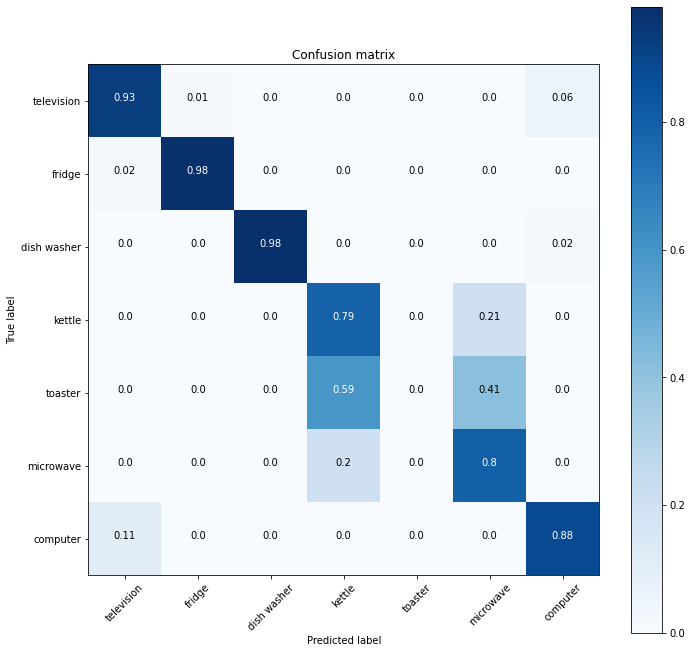

In [ ]:
#Print results and plot confusion matrix

#print('Test accuracy: ', results[1])
#print("Loss: "f"{results[0]}")
Y_pred = model_used.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
C = confusion_matrix(Y_test, y_pred)
# B =np.around((C / C.astype(np.float).sum(axis=1))*100,2)
print(confusion_matrix(Y_test, y_pred))
precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
print("F1 SCORE",fscore)
plot_confusion_matrix_norm(C, appliances, normalize=True)
print(classification_report(Y_test, y_pred, target_names=appliances))

In [ ]:
#kfold with random seed
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []
precision_per_fold = []
recall_per_fold = []
seed_per_fold = []

for seed in range(10,500,5):
    #print("TRAIN:", train_index, "TEST:", test_index)
        
    X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=seed, stratify=y_anomF)
    
    #Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
    #model = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    
    model.trainable = False
    base_output = model.layers[-2].output
    hidden = Dense(num_of_classes, activation='softmax')(base_output)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.02
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    
    #print(model.summary())
    # model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 15, verbose = 2)
    model2.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 40, verbose = 0)
    results = model2.evaluate(X_test, y_test, verbose = 2)
    
    Y_pred = model_used.predict(X_test, verbose = 2)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_test = np.argmax(y_test, axis=-1)
    
    precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
    f1_per_fold.append(round(fscore,4))
    acc_per_fold.append(round(results[1] * 100,4))
    loss_per_fold.append(round(results[0],4))
    precision_per_fold.append(round(precision,4))
    recall_per_fold.append(round(recall,4))
    seed_per_fold.append(seed)


    
    print('Test accuracy: ',acc_per_fold[-1])
    print('Test loss: ',loss_per_fold[-1])
    print('test f1: ',f1_per_fold[-1])

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3244 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.3244
test f1:  0.9252


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3726 - accuracy: 0.8540
8/8 - 0s
Test accuracy:  85.3982
Test loss:  0.3726
test f1:  0.8753


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3881 - accuracy: 0.8363
8/8 - 0s
Test accuracy:  83.6283
Test loss:  0.3881
test f1:  0.8715


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4074 - accuracy: 0.8274
8/8 - 0s
Test accuracy:  82.7434
Test loss:  0.4074
test f1:  0.8868


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3575 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.3575
test f1:  0.8942


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3325 - accuracy: 0.8673
8/8 - 0s
Test accuracy:  86.7257
Test loss:  0.3325
test f1:  0.917


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3734 - accuracy: 0.8363
8/8 - 0s
Test accuracy:  83.6283
Test loss:  0.3734
test f1:  0.8958


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3522 - accuracy: 0.8584
8/8 - 0s
Test accuracy:  85.8407
Test loss:  0.3522
test f1:  0.8737


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3498 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.3498
test f1:  0.9285


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4160 - accuracy: 0.8407
8/8 - 0s
Test accuracy:  84.0708
Test loss:  0.416
test f1:  0.8758


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3747 - accuracy: 0.8673
8/8 - 0s
Test accuracy:  86.7257
Test loss:  0.3747
test f1:  0.9198


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3587 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.3587
test f1:  0.912


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4960 - accuracy: 0.8319
8/8 - 0s
Test accuracy:  83.1858
Test loss:  0.496
test f1:  0.8992


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4358 - accuracy: 0.8407
8/8 - 0s
Test accuracy:  84.0708
Test loss:  0.4358
test f1:  0.8619


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3225 - accuracy: 0.8938
8/8 - 0s
Test accuracy:  89.3805
Test loss:  0.3225
test f1:  0.9144


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3075 - accuracy: 0.8850
8/8 - 0s
Test accuracy:  88.4956
Test loss:  0.3075
test f1:  0.8781


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4854 - accuracy: 0.8407
8/8 - 0s
Test accuracy:  84.0708
Test loss:  0.4854
test f1:  0.866


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4537 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.4537
test f1:  0.8502


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3266 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.3266
test f1:  0.9113


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4008 - accuracy: 0.8717
8/8 - 0s
Test accuracy:  87.1681
Test loss:  0.4008
test f1:  0.8757


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3010 - accuracy: 0.9027
8/8 - 0s
Test accuracy:  90.2655
Test loss:  0.301
test f1:  0.9249


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4053 - accuracy: 0.8628
8/8 - 0s
Test accuracy:  86.2832
Test loss:  0.4053
test f1:  0.9058


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4115 - accuracy: 0.8540
8/8 - 0s
Test accuracy:  85.3982
Test loss:  0.4115
test f1:  0.8992


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4531 - accuracy: 0.8363
8/8 - 0s
Test accuracy:  83.6283
Test loss:  0.4531
test f1:  0.8656


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3066 - accuracy: 0.8805
8/8 - 0s
Test accuracy:  88.0531
Test loss:  0.3066
test f1:  0.9124


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3858 - accuracy: 0.8628
8/8 - 0s
Test accuracy:  86.2832
Test loss:  0.3858
test f1:  0.9006


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3049 - accuracy: 0.8805
8/8 - 0s
Test accuracy:  88.0531
Test loss:  0.3049
test f1:  0.9204


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3803 - accuracy: 0.8451
8/8 - 0s
Test accuracy:  84.5133
Test loss:  0.3803
test f1:  0.8989


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3397 - accuracy: 0.9027
8/8 - 0s
Test accuracy:  90.2655
Test loss:  0.3397
test f1:  0.8881


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3332 - accuracy: 0.8805
8/8 - 0s
Test accuracy:  88.0531
Test loss:  0.3332
test f1:  0.9438


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3126 - accuracy: 0.8717
8/8 - 0s
Test accuracy:  87.1681
Test loss:  0.3126
test f1:  0.9437


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3705 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.3705
test f1:  0.8937


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4381 - accuracy: 0.8230
8/8 - 0s
Test accuracy:  82.3009
Test loss:  0.4381
test f1:  0.8935


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3663 - accuracy: 0.8673
8/8 - 0s
Test accuracy:  86.7257
Test loss:  0.3663
test f1:  0.8981


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3785 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.3785
test f1:  0.8936


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4723 - accuracy: 0.8540
8/8 - 0s
Test accuracy:  85.3982
Test loss:  0.4723
test f1:  0.9124


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.5994 - accuracy: 0.7920
8/8 - 0s
Test accuracy:  79.2035
Test loss:  0.5994
test f1:  0.8145


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3870 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.387
test f1:  0.8897


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3091 - accuracy: 0.8938
8/8 - 0s
Test accuracy:  89.3805
Test loss:  0.3091
test f1:  0.9275


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4430 - accuracy: 0.8407
8/8 - 0s
Test accuracy:  84.0708
Test loss:  0.443
test f1:  0.8737


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3906 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.3906
test f1:  0.8913


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.2970 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.297
test f1:  0.9054


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3081 - accuracy: 0.8850
8/8 - 0s
Test accuracy:  88.4956
Test loss:  0.3081
test f1:  0.9368


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4079 - accuracy: 0.8628
8/8 - 0s
Test accuracy:  86.2832
Test loss:  0.4079
test f1:  0.9261


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.5069 - accuracy: 0.8053
8/8 - 0s
Test accuracy:  80.531
Test loss:  0.5069
test f1:  0.8814


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3219 - accuracy: 0.8938
8/8 - 0s
Test accuracy:  89.3805
Test loss:  0.3219
test f1:  0.9303


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3682 - accuracy: 0.8717
8/8 - 0s
Test accuracy:  87.1681
Test loss:  0.3682
test f1:  0.9231


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3590 - accuracy: 0.8319
8/8 - 0s
Test accuracy:  83.1858
Test loss:  0.359
test f1:  0.9008


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3478 - accuracy: 0.8850
8/8 - 0s
Test accuracy:  88.4956
Test loss:  0.3478
test f1:  0.919


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3631 - accuracy: 0.8850
8/8 - 0s
Test accuracy:  88.4956
Test loss:  0.3631
test f1:  0.9146


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3176 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.3176
test f1:  0.9275


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4010 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.401
test f1:  0.9113


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4054 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.4054
test f1:  0.8627


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3348 - accuracy: 0.8850
8/8 - 0s
Test accuracy:  88.4956
Test loss:  0.3348
test f1:  0.9197


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3638 - accuracy: 0.8628
8/8 - 0s
Test accuracy:  86.2832
Test loss:  0.3638
test f1:  0.9076


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4446 - accuracy: 0.8363
8/8 - 0s
Test accuracy:  83.6283
Test loss:  0.4446
test f1:  0.8879


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3630 - accuracy: 0.8717
8/8 - 0s
Test accuracy:  87.1681
Test loss:  0.363
test f1:  0.8946


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4382 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.4382
test f1:  0.8922


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4160 - accuracy: 0.8097
8/8 - 0s
Test accuracy:  80.9735
Test loss:  0.416
test f1:  0.8721


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3597 - accuracy: 0.8717
8/8 - 0s
Test accuracy:  87.1681
Test loss:  0.3597
test f1:  0.8994


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4537 - accuracy: 0.8274
8/8 - 0s
Test accuracy:  82.7434
Test loss:  0.4537
test f1:  0.8805


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3878 - accuracy: 0.8451
8/8 - 0s
Test accuracy:  84.5133
Test loss:  0.3878
test f1:  0.9194


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3703 - accuracy: 0.8628
8/8 - 0s
Test accuracy:  86.2832
Test loss:  0.3703
test f1:  0.9138


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3418 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.3418
test f1:  0.9202


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4525 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.4525
test f1:  0.9004


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.5116 - accuracy: 0.8363
8/8 - 0s
Test accuracy:  83.6283
Test loss:  0.5116
test f1:  0.8709


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3787 - accuracy: 0.8540
8/8 - 0s
Test accuracy:  85.3982
Test loss:  0.3787
test f1:  0.9093


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4816 - accuracy: 0.8319
8/8 - 0s
Test accuracy:  83.1858
Test loss:  0.4816
test f1:  0.8786


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3306 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.3306
test f1:  0.9079


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3796 - accuracy: 0.8894
8/8 - 0s
Test accuracy:  88.9381
Test loss:  0.3796
test f1:  0.8856


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3825 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.3825
test f1:  0.9088


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3348 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.3348
test f1:  0.9141


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3658 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.3658
test f1:  0.897


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4443 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.4443
test f1:  0.8955


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3961 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.3961
test f1:  0.8707


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3806 - accuracy: 0.9071
8/8 - 0s
Test accuracy:  90.708
Test loss:  0.3806
test f1:  0.9313


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3854 - accuracy: 0.8584
8/8 - 0s
Test accuracy:  85.8407
Test loss:  0.3854
test f1:  0.8754


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3449 - accuracy: 0.8540
8/8 - 0s
Test accuracy:  85.3982
Test loss:  0.3449
test f1:  0.8581


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3163 - accuracy: 0.8805
8/8 - 0s
Test accuracy:  88.0531
Test loss:  0.3163
test f1:  0.918


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3808 - accuracy: 0.8673
8/8 - 0s
Test accuracy:  86.7257
Test loss:  0.3808
test f1:  0.9257


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3789 - accuracy: 0.8761
8/8 - 0s
Test accuracy:  87.6106
Test loss:  0.3789
test f1:  0.9246


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4822 - accuracy: 0.8407
8/8 - 0s
Test accuracy:  84.0708
Test loss:  0.4822
test f1:  0.8912


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3429 - accuracy: 0.8717
8/8 - 0s
Test accuracy:  87.1681
Test loss:  0.3429
test f1:  0.9067


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4747 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.4747
test f1:  0.8629


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4802 - accuracy: 0.8363
8/8 - 0s
Test accuracy:  83.6283
Test loss:  0.4802
test f1:  0.8829


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4445 - accuracy: 0.8363
8/8 - 0s
Test accuracy:  83.6283
Test loss:  0.4445
test f1:  0.8405


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3864 - accuracy: 0.8407
8/8 - 0s
Test accuracy:  84.0708
Test loss:  0.3864
test f1:  0.9054


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4132 - accuracy: 0.8407
8/8 - 0s
Test accuracy:  84.0708
Test loss:  0.4132
test f1:  0.8887


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3742 - accuracy: 0.8805
8/8 - 0s
Test accuracy:  88.0531
Test loss:  0.3742
test f1:  0.907


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.5006 - accuracy: 0.8540
8/8 - 0s
Test accuracy:  85.3982
Test loss:  0.5006
test f1:  0.9047


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3651 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.3651
test f1:  0.9171


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4230 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.423
test f1:  0.9043


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3712 - accuracy: 0.8673
8/8 - 0s
Test accuracy:  86.7257
Test loss:  0.3712
test f1:  0.9016


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.2858 - accuracy: 0.8938
8/8 - 0s
Test accuracy:  89.3805
Test loss:  0.2858
test f1:  0.9375


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3961 - accuracy: 0.8496
8/8 - 0s
Test accuracy:  84.9558
Test loss:  0.3961
test f1:  0.9059


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4768 - accuracy: 0.8363
8/8 - 0s
Test accuracy:  83.6283
Test loss:  0.4768
test f1:  0.8966


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.3143 - accuracy: 0.8850
8/8 - 0s
Test accuracy:  88.4956
Test loss:  0.3143
test f1:  0.9144


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


8/8 - 0s - loss: 0.4076 - accuracy: 0.8628
8/8 - 0s
Test accuracy:  86.2832
Test loss:  0.4076
test f1:  0.9226


# KFOLD

In [ ]:
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []

# X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=42)
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
# y_train[0]

#y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)

skf = StratifiedKFold(n_splits=5,shuffle=False)
print("num of splits:",skf.get_n_splits(data))

for train_index, test_index in skf.split(data, labels):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
#     train_l = []
#     test_l = []
    
#     for n in range(num_of_classes):
#         train_l.append(len(y_train[y_train==n]))
#         test_l.append(len(y_test[y_test==n]))
    
#     print('>Train:', (train_l),"all",sum(train_l))
#     print('>test:', (test_l),"all",sum(test_l))


    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)
    
    
    
    #Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
    #model = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    
    model.trainable = False
    base_output = model.layers[-2].output
    hidden = Dense(num_of_classes, activation='softmax')(base_output)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.02
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    
    #print(model.summary())
    # model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 15, verbose = 2)
    model2.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 40, verbose = 1)
    results = model2.evaluate(X_test, y_test, verbose = 2)
    
    precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
    f1_per_fold.append(round(fscore,4))
    acc_per_fold.append(round(results[1] * 100,4))
    loss_per_fold.append(round(results[0],4))
    
    
    print('Test accuracy: ',acc_per_fold[-1])
    print('Test loss: ',loss_per_fold[-1])
    

num of splits: 5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/40
90/90 [==============================] - 2s 14ms/step - loss: 0.6109 - accuracy: 0.8139 - val_loss: 7.0851 - val_accuracy: 0.0497
Epoch 2/40
90/90 [==============================] - 1s 10ms/step - loss: 0.2853 - accuracy: 0.9125 - val_loss: 8.0047 - val_accuracy: 0.0387
Epoch 3/40
90/90 [==============================] - 1s 10ms/step - loss: 0.2319 - accuracy: 0.9347 - val_loss: 8.5519 - val_accuracy: 0.0442
Epoch 4/40
90/90 [==============================] - 1s 10ms/step - loss: 0.2291 - accuracy: 0.9250 - val_loss: 9.0033 - val_accuracy: 0.0442
Epoch 5/40
90/90 [==============================] - 1s 10ms/step - loss: 0.2197 - accuracy: 0.9347 - val_loss: 9.1938 - val_accuracy: 0.0442
Epoch 6/40
90/90 [==============================] - 1s 10ms/step - loss: 0.2030 - accuracy: 0.9347 - val_loss: 9.5593 - val_accuracy: 0.0442
Epoch 7/40
90/90 [==============================] - 1s 10ms/step - loss: 0.2226 - accuracy: 0.9306 - val_loss: 10.3020 - val_accuracy: 0.0552
Epoch 8/40
9

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/40
90/90 [==============================] - 2s 13ms/step - loss: 0.6690 - accuracy: 0.7958 - val_loss: 6.5573 - val_accuracy: 0.0442
Epoch 2/40
90/90 [==============================] - 1s 10ms/step - loss: 0.2408 - accuracy: 0.9333 - val_loss: 7.6292 - val_accuracy: 0.0387
Epoch 3/40
90/90 [==============================] - 1s 10ms/step - loss: 0.1906 - accuracy: 0.9431 - val_loss: 8.6077 - val_accuracy: 0.0497
Epoch 4/40
90/90 [==============================] - 1s 10ms/step - loss: 0.1697 - accuracy: 0.9472 - val_loss: 8.9187 - val_accuracy: 0.0442
Epoch 5/40
90/90 [==============================] - 1s 10ms/step - loss: 0.1652 - accuracy: 0.9472 - val_loss: 9.3793 - val_accuracy: 0.0442
Epoch 6/40
90/90 [==============================] - 1s 10ms/step - loss: 0.1600 - accuracy: 0.9486 - val_loss: 10.1919 - val_accuracy: 0.0442
Epoch 7/40
90/90 [==============================] - 1s 10ms/step - loss: 0.1747 - accuracy: 0.9361 - val_loss: 10.0330 - val_accuracy: 0.0497
Epoch 8/40


KeyboardInterrupt: 

In [ ]:
model2.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 100, 100, 16)  800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 100, 100, 16)  12560     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 50, 50, 16)    2320      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 50, 50, 16)    2320      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 25, 25, 16)    0   

In [ ]:
acc_stat = f1_per_fold

In [ ]:
len(acc_stat)

98

In [ ]:
count = 0
for i in range(10,500,5):
    count +=1
    if count == 36:
        print(i)

185


In [ ]:
np.std(acc_stat)

0.023160990470872278

In [ ]:
acc_stat.sort()

In [ ]:
for element in acc_stat:
    print(element*100)

81.45
84.05
85.02
85.81
86.19
86.27
86.29
86.56
86.6
87.07000000000001
87.09
87.15
87.21
87.37
87.37
87.53
87.53999999999999
87.57000000000001
87.58
87.81
87.86
88.05
88.14
88.29
88.56
88.68
88.79
88.81
88.87
88.97
89.12
89.13
89.22
89.35
89.36
89.37
89.42
89.46
89.55
89.58
89.66
89.7
89.81
89.89
89.92
89.92
89.94
90.03999999999999
90.06
90.08
90.16
90.42999999999999
90.47
90.53999999999999
90.53999999999999
90.58
90.59
90.67
90.7
90.75999999999999
90.79
90.88000000000001
90.93
91.13
91.13
91.2
91.24
91.24
91.38
91.41
91.44
91.44
91.46
91.7
91.71000000000001
91.8
91.9
91.94
91.97
91.97999999999999
92.02
92.04
92.25999999999999
92.31
92.46
92.49000000000001
92.52
92.57
92.61
92.75
92.75
92.85
93.03
93.13
93.67999999999999
93.75
94.37
94.38


In [ ]:
f1_per_fold

[0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714,
 0.8714]

In [ ]:
#print(np.mean(acc_per_fold))
print(np.mean(recall_per_fold))

0.9080571428571427


In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

# Testing LSTM

In [ ]:
#User LSTM_Dense2 to change parameters of different models so that you live lstm34 intact. Otherwise the same as upper training method

model = LSTM_Dense2(X_train,num_of_classes,lr = 0.001)
print(model.summary())
model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 20, verbose = 2)
results = model.evaluate(X_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])

In [ ]:
print('Test accuracy: ', results[1])
print("Loss: "f"{results[0]}")
Y_pred = model.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred, target_names=appliances))